**RESEARCH AIM**:

---
*   Comparison of trannsfer learning models
(VGG16, MobileNetV2) and custom built ALL CNN image
classification models.
*   And also comparison of the effect of segmentation on the accuracy of both the transfer learning and custom models.

**RESEARCH BY**: Benedict Ibe

**DURATION**: January 2024 - April 2024

**DATA SOURRCE**:

---

https://www.kaggle.com/datasets/mehradaria/leukemia

**STEPS TO LOADING THE DATA AND RUNNING THE NOTEBOOK**

---
1.   Download the data as a zip file from the link above
2.   Make sure the data is saved as or renamed to 'all_data.zip', so as to match the unzipping code, else it wont work.

3.   upload the zip file into google colab where this notebook was loaded.

4.   Click on run all

In [1]:
!pip install numpy opencv-python Pillow

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [3]:
#Import the required libraries
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Sequential

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.models import load_model
from tensorflow import keras

import keras_tuner as kt
from keras_tuner import BayesianOptimization, Hyperband, Objective
from keras_tuner import HyperModel
from tensorflow.keras import regularizers
from keras_tuner import BayesianOptimization

In [4]:
#Unzipping the dataset file
with zipfile.ZipFile('/content/all_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Dataset')

In [5]:
#Define the path or directory where the unzipped file is created
raw_data_dir = '/content/Dataset'

In [6]:
#Initialize an empty list of the dataframe columns to be created
df = pd.DataFrame(columns=['IMAGE', 'Class', 'image_type'])

Given that there are two main folders, one containing the original peripheral blood smear images (PBS) and the other containing the segmented PBS, we will put them in a column so that we can easily select the image type we want to feed into our model to train with

#What this code does is that it will go through each main directory which is either the originnal or segmented image directory, then, go through each sub-directory inside the main directory which basically constitutes the class label, then go through each image whithin each class label folder, and write the path to the image as the IMAGE_PATH in the dataframe we are creating, while putting the class label it belongs to and the type of image it is(Original or Segmented)


In [7]:
# Iterate or go through each data type directory (Original and Segmented)
for image_type in ['Original', 'Segmented']:
    type_dir = os.path.join(raw_data_dir, image_type)

    if not os.path.exists(type_dir):
        print(f"Directory {type_dir} does not exist. Check the zip extraction and path.")
        continue

    for class_label in ['Benign', 'Early', 'Pre', 'Pro']:
        class_dir = os.path.join(type_dir, class_label)

        if not os.path.exists(class_dir):
            print(f"Class directory {class_dir} does not exist. Check the dataset structure.")
            continue

        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            # Create a new DataFrame for the current row and append it to the existing DataFrame
            new_row = pd.DataFrame({
                'IMAGE': [image_path],
                'Class': [class_label],
                'image_type': [image_type]
            })
            df = pd.concat([df, new_row], ignore_index=True)

In [8]:
df.head()

,IMAGE,Class,image_type
0,/content/Dataset/Original/Benign/WBC-Benign-11...,Benign,Original
1,/content/Dataset/Original/Benign/WBC-Benign-48...,Benign,Original
2,/content/Dataset/Original/Benign/WBC-Benign-27...,Benign,Original
3,/content/Dataset/Original/Benign/WBC-Benign-23...,Benign,Original
4,/content/Dataset/Original/Benign/WBC-Benign-08...,Benign,Original


NOTE: When it comes to diagnosing acute lymphoblastic leukemia (ALL) from peripheral blood smear (PBS) images, using a segmented image dataset offers numerous important advantages for image classification tasks. Segmentation separates the regions of interest (ROIs) from the background and concentrates on the cells that are essential for diagnosis. This is especially true when segmentation is carried out using color thresholding in the HSV color space. Thus Segmented images has been shown to reduce the nnoise withing the images thus ensuring higher accuracy.

In [9]:
#Define the image type to be used
data_type = 'Segmented'

In [10]:
#Select the image type to be used for the analysis (Here we used the segmented images as it is most preferred but you can still choose the original images and train with it to see the accuracy)
segmennted_df = df[(df['image_type'] == data_type)]

In [11]:
segmennted_df

,IMAGE,Class,image_type
3256,/content/Dataset/Segmented/Benign/WBC-Benign-1...,Benign,Segmented
3257,/content/Dataset/Segmented/Benign/WBC-Benign-4...,Benign,Segmented
3258,/content/Dataset/Segmented/Benign/WBC-Benign-2...,Benign,Segmented
3259,/content/Dataset/Segmented/Benign/WBC-Benign-2...,Benign,Segmented
3260,/content/Dataset/Segmented/Benign/WBC-Benign-0...,Benign,Segmented
...,...,...,...
6507,/content/Dataset/Segmented/Pro/WBC-Malignant-P...,Pro,Segmented
6508,/content/Dataset/Segmented/Pro/WBC-Malignant-P...,Pro,Segmented
6509,/content/Dataset/Segmented/Pro/WBC-Malignant-P...,Pro,Segmented
6510,/content/Dataset/Segmented/Pro/WBC-Malignant-P...,Pro,Segmented


In [12]:
#Inspect the number of rows of the segmented images
rows = segmennted_df.shape[0]
rows

3256

In [13]:
#Use the group by function on the class label column of the dataframe to check for class imbalance
grouped_class = segmennted_df.groupby(['Class']).count()
grouped_class

,IMAGE,image_type
Class,,
Benign,504,504
Early,985,985
Pre,963,963
Pro,804,804


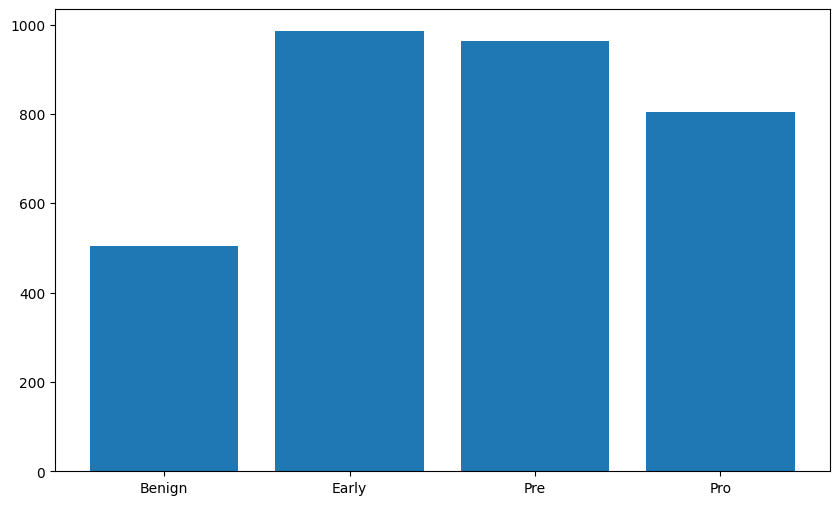

In [14]:
#Plot the grouped data in a bar chart to see the class balance
plt.figure(figsize=(10, 6))
bar_plot = plt.bar(x=grouped_class.index, height=grouped_class['IMAGE'])

#Treating class imbalance

Given the imbalance as seen in Benign and Pro, we will use data augmentation on the training data to balance the dataset during training.

In [15]:
classes = ['Pro', 'Benign', 'Pre', 'Early']
image_types = ['Original', 'Segmented']

In the code below, we aim to visualize the difference between the original image of a PBS and the segmented image to see the difference. Notice from the result of the plot how the segmented images ignored other details of the PBS while highlighting onnly the blood cells of interest, whereas the original blood sample images showed all the cells.

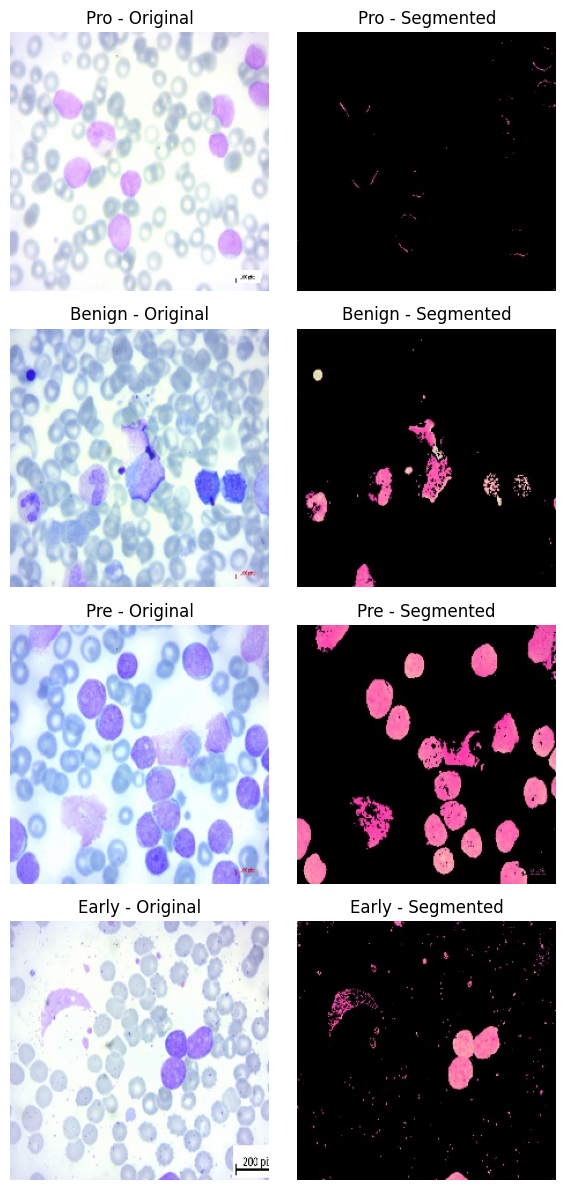

In [16]:
# Setting up the plot
fig, axs = plt.subplots(len(classes), len(image_types), figsize=(3 * len(image_types), 3 * len(classes)))

for i, cls in enumerate(classes):
    for j, img_type in enumerate(image_types):
        # Filter the DataFrame for the current class and image type.
        filtered_df = df[(df['Class'] == cls) & (df['image_type'] == img_type)]

        if not filtered_df.empty:
            # Selecting the first image for demonstration if the filtered current class is not empty
            image_path = filtered_df.iloc[0]['IMAGE']
            class_label = filtered_df.iloc[0]['Class']

            # Load selected images and display the them
            img = mpimg.imread(image_path)
            if len(classes) > 1 or len(image_types) > 1:  # Get more than one subplot
                axs[i, j].imshow(img)
                axs[i, j].set_title(f'{class_label} - {img_type}')
                axs[i, j].axis('off')
            else:  # Plot a single subplot
                axs.imshow(img)
                axs.set_title(f'{class_label} - {img_type}')
                axs.axis('off')
        else:
            print(f"No images found for Class: {cls} - {img_type}")

plt.tight_layout()
plt.show()


#Encode the data frame

In [17]:
#Convert the class label to numerical using the replace function
segmennted_df['Class'] = segmennted_df['Class'].replace('Benign', 0)
segmennted_df['Class'] = segmennted_df['Class'].replace('Early', 1)
segmennted_df['Class'] = segmennted_df['Class'].replace('Pre', 2)
segmennted_df['Class'] = segmennted_df['Class'].replace('Pro', 3)

<ipython-input-17-ff5ece3c4889>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmennted_df['Class'] = segmennted_df['Class'].replace('Benign', 0)
<ipython-input-17-ff5ece3c4889>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmennted_df['Class'] = segmennted_df['Class'].replace('Early', 1)
<ipython-input-17-ff5ece3c4889>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [18]:
# Splitting the dataset into training and temp (temporary split is used for further splitting into validation and test)
train_data, val_test_data = train_test_split(segmennted_df, test_size=0.2, stratify=segmennted_df['Class'], random_state=42)


# Further splitting the temp dataset into validation and test dataset
val_data, test_data = train_test_split(val_test_data, test_size=0.5, stratify=val_test_data['Class'], random_state=42)

In [19]:
train_data

,IMAGE,Class,image_type
5791,/content/Dataset/Segmented/Pro/WBC-Malignant-P...,3,Segmented
6151,/content/Dataset/Segmented/Pro/WBC-Malignant-P...,3,Segmented
4627,/content/Dataset/Segmented/Early/WBC-Malignant...,1,Segmented
3846,/content/Dataset/Segmented/Early/WBC-Malignant...,1,Segmented
3749,/content/Dataset/Segmented/Benign/WBC-Benign-3...,0,Segmented
...,...,...,...
3875,/content/Dataset/Segmented/Early/WBC-Malignant...,1,Segmented
4613,/content/Dataset/Segmented/Early/WBC-Malignant...,1,Segmented
4064,/content/Dataset/Segmented/Early/WBC-Malignant...,1,Segmented
4934,/content/Dataset/Segmented/Pre/WBC-Malignant-P...,2,Segmented


In [20]:
#Initialize or define the batch size and the image size
batch_size = 128
target_size = (220, 220)

#Create a tensor flow data from the training, test and validation data

In [21]:
train_tf_data = tf.data.Dataset.from_tensor_slices((train_data['IMAGE'].values, train_data['Class'].values))
val_tf_data = tf.data.Dataset.from_tensor_slices((val_data['IMAGE'].values, val_data['Class'].values))
test_tf_data = tf.data.Dataset.from_tensor_slices((test_data['IMAGE'].values, test_data['Class'].values))

#Define the image loader and pre-processor
Here we only set the shape and then resize the images to be used for training

In [22]:
def load_and_preprocess_image(image_path, label):
    # Load and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)

    # set the shape of the image
    image.set_shape((None, None, 3))

    # Set the size of the image
    image = tf.image.resize(image, (220, 220))

    return image, label

In [23]:
#Apply the Pre-processing function to the datasets
train_tf_data = train_tf_data.map(load_and_preprocess_image)
val_tf_data = val_tf_data.map(load_and_preprocess_image)
test_tf_data = test_tf_data.map(load_and_preprocess_image)

In [24]:
#Shuffle the dataset
train_tf_data = train_tf_data.shuffle(buffer_size=len(train_data)).batch(batch_size=batch_size)
val_tf_data = val_tf_data.shuffle(buffer_size=len(val_data)).batch(batch_size=batch_size)
test_tf_data = test_tf_data.shuffle(buffer_size=len(test_data)).batch(batch_size=batch_size)

In [25]:
data_iterator = train_tf_data.as_numpy_iterator()

In [26]:
batch = data_iterator.next()

In [27]:
batch[0].shape

(128, 220, 220, 3)

#View the first four images and their labels

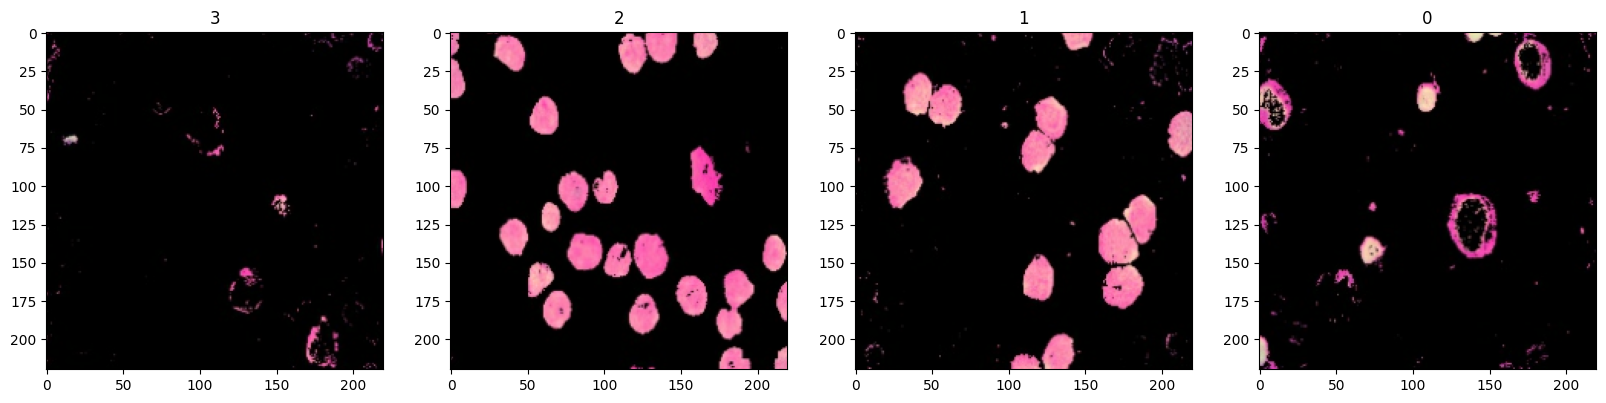

In [28]:
#View a batch image and its corresponding label using matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

if len(batch[0]) >= 4:
    for idx, img in enumerate(batch[0][:4]):
        ax[idx].imshow(img/255)
        ax[idx].set_title(str(batch[1][idx]))
    plt.show()
else:
    print("The batch does not contain enough images to display 4 images.")

In [29]:
# Initialize the Data augmentation variable, where we apply random flip and random rotation on the image
all_augmentation_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(220, 220),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Remember previously where we observed a that the claass labels were imbalance, and as such to solve this problem, which could pottentially affect our model, we apply data augmentation techniques to only the training data and not to the validation and test data

In [30]:
#Apply the augmentation parameter to only the training data
train_aug_data = train_tf_data.map(lambda x, y: (all_augmentation_rescale(x, training=True), y))

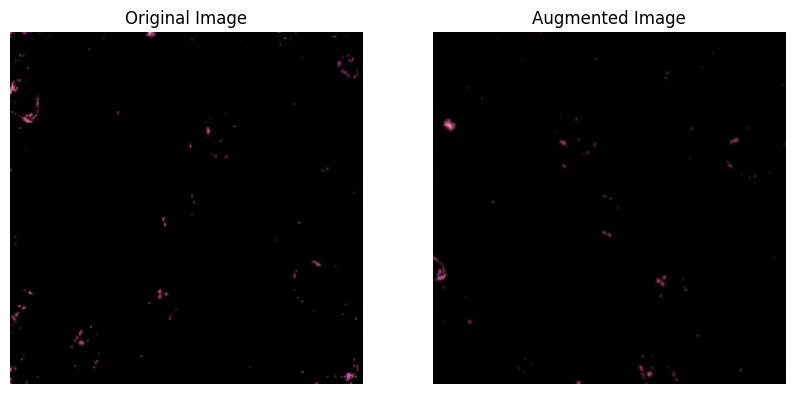

In [31]:
#Here we view an image in to forms, on one hand we view the normal image, and on the other hand, we view the segmented version of the image
import matplotlib.pyplot as plt

# Take one batch of images and labels
for images, labels in train_tf_data.take(1):
    # Original image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title("Original Image")
    plt.axis("off")


  # Augmented image
    augmented_images = all_augmentation_rescale(images, training=True)
    plt.subplot(1, 2, 2)
    # The pixel values should be clipped to the range [0, 1] for proper display
    plt.imshow(tf.clip_by_value(augmented_images[0]/255, 0, 1).numpy())
    plt.title("Augmented Image")
    plt.axis("off")

plt.show()

In [32]:
# Calculate the number of batches in the training dataset
num_batches_train = train_aug_data.cardinality().numpy()

# Calculate the total number of samples in the training dataset
num_samples_train = num_batches_train * batch_size

print("Number of batches in the training dataset:", num_batches_train)
print("Number of samples in the training dataset:", num_samples_train)

Number of batches in the training dataset: 21
Number of samples in the training dataset: 2688


In [33]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00


In [35]:
num_classes = 4

In [36]:
train_norm_data = train_aug_data.map(lambda x, y: (x / 255.0, y))
val_norm_data = val_tf_data.map(lambda x, y: (x / 255.0, y))

In [37]:
class MyHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same",
                                         activation="relu", input_shape=self.input_shape))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'))
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'))
        model.add(tf.keras.layers.Flatten())

        # Dynamic addition of dense layers
        for i in range(hp.Int('num_dense_layers', 1, 3)):
            model.add(tf.keras.layers.Dense(units=hp.Int(f'units_{i}', min_value=128, max_value=512, step=64), activation='relu'))

        model.add(tf.keras.layers.Dense(units=self.num_classes, activation='softmax'))

        model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model



In [38]:
# Assuming `input_shape` and `num_classes` are defined based on your dataset
hypermodel = MyHyperModel(input_shape=(220, 220, 3), num_classes=num_classes)

tuner = BayesianOptimization(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,
    directory='/tmp',
    project_name='kt_bayesian_opt',
    overwrite=True
)

# Assuming `train_aug_data` and `val_tf_data` are your training and validation datasets
tuner.search(train_norm_data, validation_data=val_norm_data, epochs=20, callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)])


Trial 5 Complete [00h 09m 52s]
val_accuracy: 0.9509202241897583

Best val_accuracy So Far: 0.9570552110671997
Total elapsed time: 00h 50m 04s


In [39]:
# Get the best hyperparameters.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# You can then print these out to see what they were.
print('Best hyperparameters found were: ', best_hps.values)

# Get the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Now you can use `best_model` for further predictions or evaluation as needed.

Best hyperparameters found were:  {'num_dense_layers': 1, 'units_0': 256}


#TRAINING WITH THE TRANSFER MODELS

In [40]:
# Load the base Mobile net model, which has been pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(220, 220, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [41]:
# Load the base VGG16 model, which has been pre-trained on ImageNet
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(220, 220, 3)))

58889256/58889256 [==============================] - 0s 0us/step


Freezing the layers ensures that the learned features ikn the transfer learning algorithm which has been trained on a large image in image net are preserved and utilized as-is, without being distorted by the new training process on a potentially smaller or more specific dataset. It can also help in prevennting overfitting by concentrating only on the features of the current dataset. and can most importantly increase training and computational time.

In [42]:
# Freeze the base model layers to prevent them from being updated during training
base_model.trainable = False

In [43]:
# Freeze the layers of the base model
base_model_vgg.trainable = False

Below we use the functional method to initialize our transfer learning model adapting the output or dense layer to the number of classes we have

In [44]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add a logistic layer for the classes. given we have 4 classes.
predictions = Dense(4, activation='softmax')(x)

# This is the model we will train
model_Mnet = Model(inputs=base_model.input, outputs=predictions)
model_Mnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 220, 220, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 110, 110, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 110, 110, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 110, 110, 32)         0         ['bn_Conv1[0][0]']        

In [45]:
model_Mnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
history = model_Mnet.fit(
    train_aug_data,
    validation_data=val_tf_data,
    epochs=10
)

Epoch 1/10
21/21 [==============================] - 30s 1s/step - loss: 0.9800 - accuracy: 0.7185 - val_loss: 0.4124 - val_accuracy: 0.8037
Epoch 2/10
21/21 [==============================] - 26s 1s/step - loss: 0.3238 - accuracy: 0.8806 - val_loss: 0.2650 - val_accuracy: 0.9202
Epoch 3/10
21/21 [==============================] - 26s 1s/step - loss: 0.2464 - accuracy: 0.9171 - val_loss: 0.2841 - val_accuracy: 0.9110
Epoch 4/10
21/21 [==============================] - 26s 1s/step - loss: 0.2176 - accuracy: 0.9236 - val_loss: 0.3057 - val_accuracy: 0.8896
Epoch 5/10
21/21 [==============================] - 26s 1s/step - loss: 0.2057 - accuracy: 0.9293 - val_loss: 0.2231 - val_accuracy: 0.9356
Epoch 6/10
21/21 [==============================] - 26s 1s/step - loss: 0.1842 - accuracy: 0.9316 - val_loss: 0.2435 - val_accuracy: 0.9202
Epoch 7/10
21/21 [==============================] - 26s 1s/step - loss: 0.1916 - accuracy: 0.9293 - val_loss: 0.2109 - val_accuracy: 0.9233
Epoch 8/10
21/21 [==

In [47]:
# Add the transfer learning functional model layers, VGG16 does not include global average pooling, so we flatten the output
x = base_model_vgg.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions_vgg = Dense(4, activation='softmax')(x)  # Given that there are 4 classes

# Create and compile the VGG16 model
model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions_vgg)
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Get the summary of the model
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 220, 220, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 220, 220, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 220, 220, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 110, 110, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 110, 110, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 110, 110, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 55, 55, 128)       0   

The optimizer is in charge of modifying the network's weights in order to minimize the loss function. In this case we used the adam optimizer because it is well-suited for a variety of issues and is renowned for its practical efficiency. During training, it automatically modifies the learning rate, accelerating the convergence to the ideal set of weights.

The loss function on the other hand, measures how well the model is performing by computing the difference between the model's predictions and the actual labels.

while the metrics is used to evaluate the performance of your model.

In [48]:
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [49]:
#Apply the VGG16 model on the training data and validate it on the validation data
history_vgg = model_vgg.fit(train_aug_data, validation_data=val_tf_data, epochs=10)


Epoch 1/10
21/21 [==============================] - 50s 2s/step - loss: 26.4626 - accuracy: 0.6348 - val_loss: 3.7287 - val_accuracy: 0.7454
Epoch 2/10
21/21 [==============================] - 49s 2s/step - loss: 1.6332 - accuracy: 0.8844 - val_loss: 0.6566 - val_accuracy: 0.9202
Epoch 3/10
21/21 [==============================] - 49s 2s/step - loss: 0.6564 - accuracy: 0.9136 - val_loss: 0.4084 - val_accuracy: 0.9356
Epoch 4/10
21/21 [==============================] - 49s 2s/step - loss: 0.3631 - accuracy: 0.9343 - val_loss: 0.4157 - val_accuracy: 0.9233
Epoch 5/10
21/21 [==============================] - 49s 2s/step - loss: 0.3389 - accuracy: 0.9336 - val_loss: 0.3375 - val_accuracy: 0.9325
Epoch 6/10
21/21 [==============================] - 49s 2s/step - loss: 0.2247 - accuracy: 0.9401 - val_loss: 0.3041 - val_accuracy: 0.9387
Epoch 7/10
21/21 [==============================] - 49s 2s/step - loss: 0.1576 - accuracy: 0.9578 - val_loss: 0.2832 - val_accuracy: 0.9356
Epoch 8/10
21/21 [=

In [50]:
all_tuned = Sequential()

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Resizing

num_classes = 4  # Based on the number of classes in our dataset

all_tuned = Sequential([
    # Resizing preprocessing step as the input layer
    Resizing(220, 220, interpolation="bilinear", input_shape=(None, None, 3)),

    # Rescaling preprocessing step
    Rescaling(1./255),

    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Convolutional layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the output for the dense layers
    Flatten(),

    # First dense layer
    Dense(128, activation='relu'),
    # Second dense layer
    Dense(128, activation='relu'),
    # Third dense layer
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output layer with softmax for a multi-classification problem
    Dense(num_classes, activation='softmax')
])

# Compile the model
all_tuned.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Model summary to see the full architecture
all_tuned.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 220, 220, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 220, 220, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 109, 109, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 53, 53, 64)        0         
 g2D)                                                 

In [52]:
import tensorflow as tf

In [53]:
ALL_tunedModel = all_tuned.fit(train_aug_data, validation_data=val_tf_data, epochs=20)

Epoch 1/20
21/21 [==============================] - 32s 1s/step - loss: 1.1753 - accuracy: 0.4547 - val_loss: 0.7704 - val_accuracy: 0.7055
Epoch 2/20
21/21 [==============================] - 31s 1s/step - loss: 0.6883 - accuracy: 0.7281 - val_loss: 0.5998 - val_accuracy: 0.7607
Epoch 3/20
21/21 [==============================] - 31s 1s/step - loss: 0.5734 - accuracy: 0.7711 - val_loss: 0.4706 - val_accuracy: 0.7822
Epoch 4/20
21/21 [==============================] - 31s 1s/step - loss: 0.4922 - accuracy: 0.8007 - val_loss: 0.4746 - val_accuracy: 0.7914
Epoch 5/20
21/21 [==============================] - 31s 1s/step - loss: 0.4829 - accuracy: 0.8118 - val_loss: 0.3756 - val_accuracy: 0.8282
Epoch 6/20
21/21 [==============================] - 31s 1s/step - loss: 0.4349 - accuracy: 0.8145 - val_loss: 0.3581 - val_accuracy: 0.8374
Epoch 7/20
21/21 [==============================] - 31s 1s/step - loss: 0.4124 - accuracy: 0.8314 - val_loss: 0.4027 - val_accuracy: 0.8282
Epoch 8/20
21/21 [==

In [54]:
all_model = Sequential()

In [55]:
#Using the sequencial mode, we build our custom model by stacking our layers in a sequence which contains our neurones
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Resizing

num_classes = 4  # Based on the number of classes in our dataset

all_model = Sequential([
    # We add resizing preprocessing step as the input layer so that images that are to be predicted will be automatically resized
    Resizing(220, 220, interpolation="bilinear", input_shape=(None, None, 3)),

    # We add rescaling or standardization preprocessing also, so that images that are to be predicted will be automatically rescaled
    Rescaling(1./255),

    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Convolutional layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flattening the 3D output to 1D
    Flatten(),

    # Dense layer
    Dense(512, activation='relu'),
    Dropout(0.5),

    # We used softmax in the output layer because it is a multiclassification problem
    Dense(num_classes, activation='softmax')
])

# Compile the model
all_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Suitable for integer labels
              metrics=['accuracy'])

# Model summary to see the full architecture
all_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 220, 220, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 220, 220, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 109, 109, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 53, 53, 64)        0         
 g2D)                                                 

In [56]:
ALL_model = all_model.fit(train_aug_data, validation_data=val_tf_data, epochs=20)

Epoch 1/20
21/21 [==============================] - 34s 2s/step - loss: 1.2601 - accuracy: 0.4796 - val_loss: 0.6725 - val_accuracy: 0.7638
Epoch 2/20
21/21 [==============================] - 33s 2s/step - loss: 0.6413 - accuracy: 0.7377 - val_loss: 0.5394 - val_accuracy: 0.7699
Epoch 3/20
21/21 [==============================] - 33s 2s/step - loss: 0.5324 - accuracy: 0.7669 - val_loss: 0.5007 - val_accuracy: 0.7822
Epoch 4/20
21/21 [==============================] - 34s 2s/step - loss: 0.5007 - accuracy: 0.7876 - val_loss: 0.4102 - val_accuracy: 0.8006
Epoch 5/20
21/21 [==============================] - 33s 2s/step - loss: 0.4734 - accuracy: 0.8118 - val_loss: 0.3633 - val_accuracy: 0.8282
Epoch 6/20
21/21 [==============================] - 34s 2s/step - loss: 0.4408 - accuracy: 0.8145 - val_loss: 0.3461 - val_accuracy: 0.8558
Epoch 7/20
21/21 [==============================] - 34s 2s/step - loss: 0.4170 - accuracy: 0.8341 - val_loss: 0.2624 - val_accuracy: 0.8834
Epoch 8/20
21/21 [==

In [57]:
import numpy

#HYPER PARAMETER TUNNING

#EVALUATION OF THE MODELS

Plot a graph to show the training performance during the epochs, The first graph shows the training and validation loss during the epochs while the second plot shows the traininng and validation accuracy during epochs


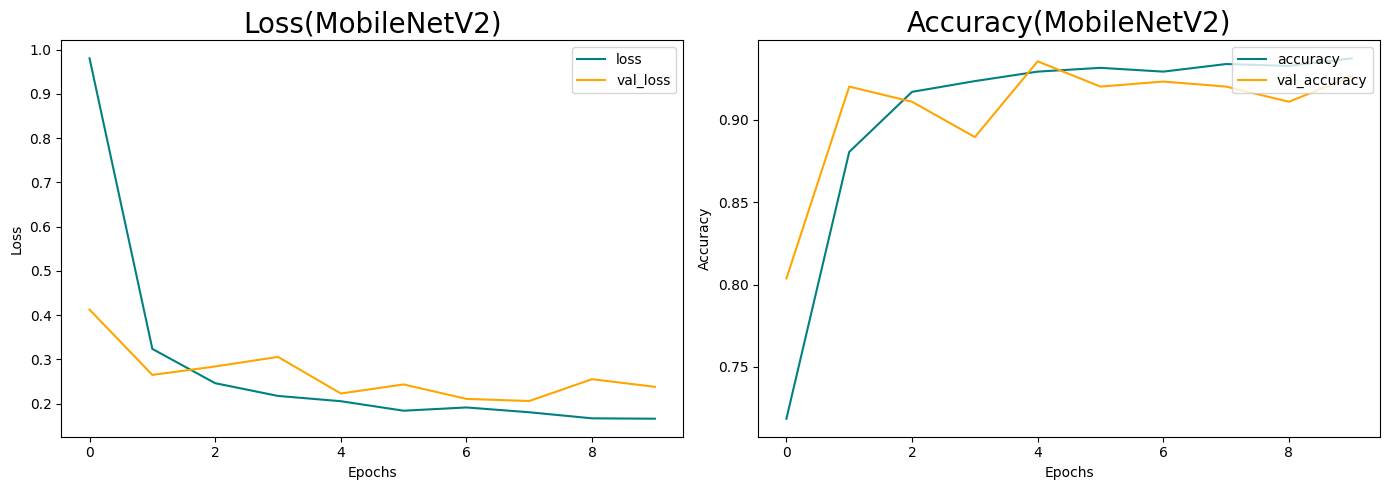

In [58]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss and val_loss on the first subplot
axs[0].plot(history.history['loss'], color='teal', label='loss')
axs[0].plot(history.history['val_loss'], color='orange', label='val_loss')
axs[0].set_title('Loss(MobileNetV2)', fontsize=20)
axs[0].legend(loc="upper right")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

# Plot accuracy and val_accuracy on the second subplot
axs[1].plot(history.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_title('Accuracy(MobileNetV2)', fontsize=20)
axs[1].legend(loc="upper right")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

# Display the plot
plt.tight_layout()
plt.show()

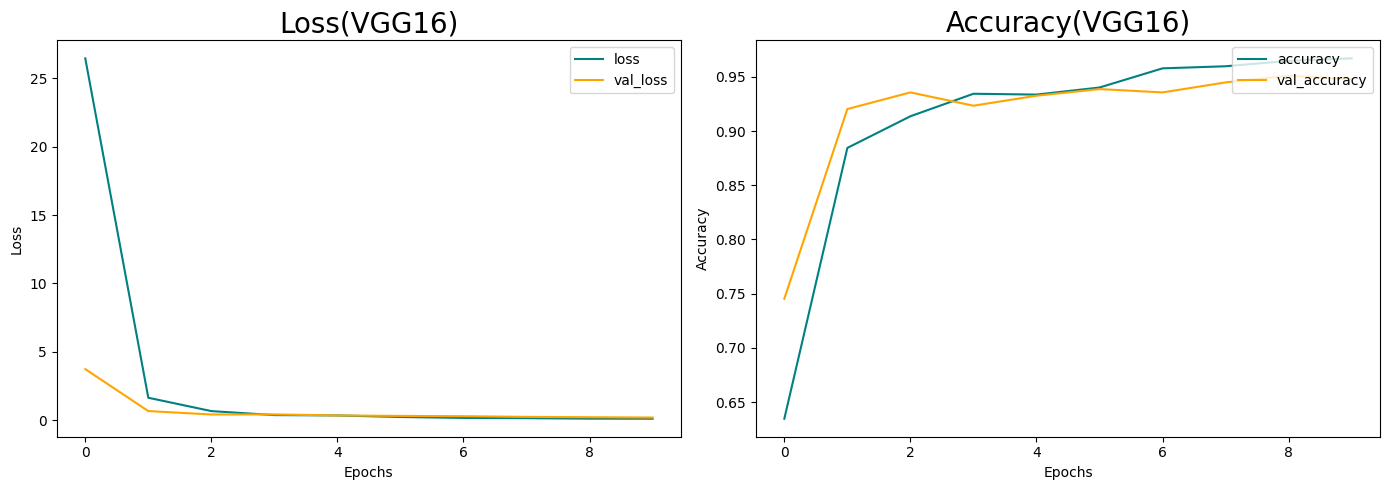

In [59]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss and val_loss on the first subplot
axs[0].plot(history_vgg.history['loss'], color='teal', label='loss')
axs[0].plot(history_vgg.history['val_loss'], color='orange', label='val_loss')
axs[0].set_title('Loss(VGG16)', fontsize=20)
axs[0].legend(loc="upper right")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

# Plot accuracy and val_accuracy on the second subplot
axs[1].plot(history_vgg.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(history_vgg.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_title('Accuracy(VGG16)', fontsize=20)
axs[1].legend(loc="upper right")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

# Display the plot
plt.tight_layout()
plt.show()

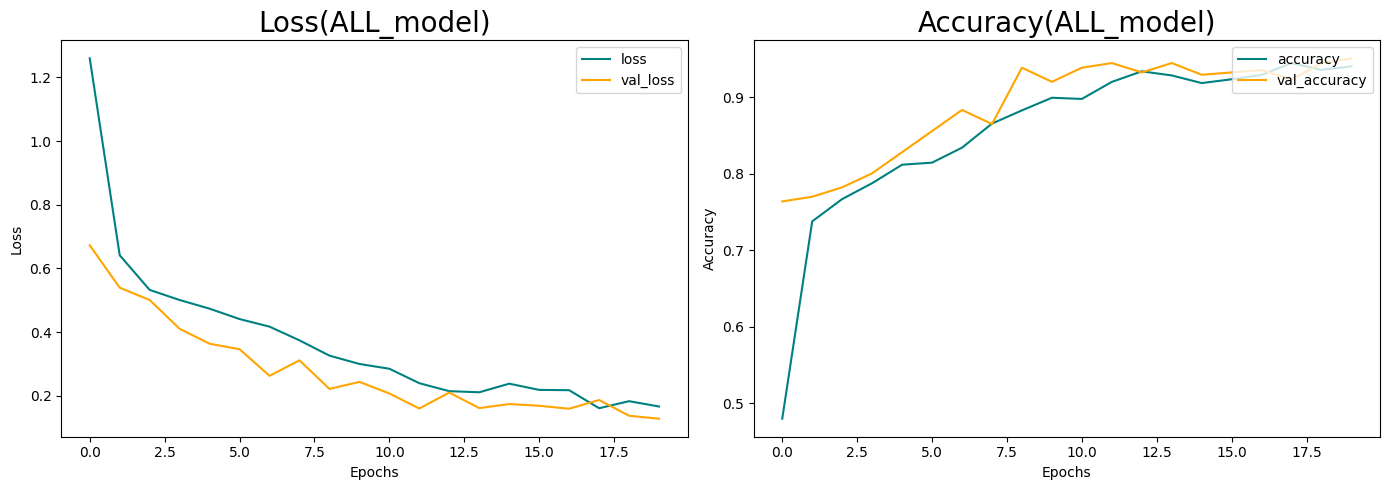

In [60]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss and val_loss on the first subplot
axs[0].plot(ALL_model.history['loss'], color='teal', label='loss')
axs[0].plot(ALL_model.history['val_loss'], color='orange', label='val_loss')
axs[0].set_title('Loss(ALL_model)', fontsize=20)
axs[0].legend(loc="upper right")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

# Plot accuracy and val_accuracy on the second subplot
axs[1].plot(ALL_model.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(ALL_model.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_title('Accuracy(ALL_model)', fontsize=20)
axs[1].legend(loc="upper right")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

# Display the plot
plt.tight_layout()
plt.show()

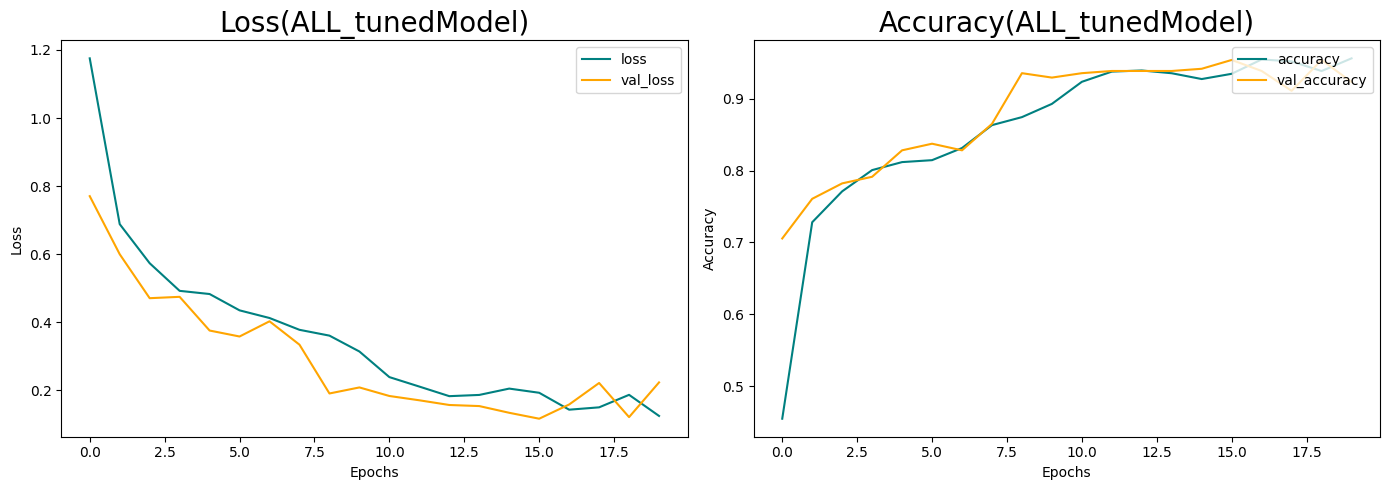

In [61]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss and val_loss on the first subplot
axs[0].plot(ALL_tunedModel.history['loss'], color='teal', label='loss')
axs[0].plot(ALL_tunedModel.history['val_loss'], color='orange', label='val_loss')
axs[0].set_title('Loss(ALL_tunedModel)', fontsize=20)
axs[0].legend(loc="upper right")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

# Plot accuracy and val_accuracy on the second subplot
axs[1].plot(ALL_tunedModel.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(ALL_tunedModel.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_title('Accuracy(ALL_tunedModel)', fontsize=20)
axs[1].legend(loc="upper right")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

# Display the plot
plt.tight_layout()
plt.show()

Using the model.evaluate function, we evaluate how each model has performed

In [63]:
loss, accuracy = all_model.evaluate(test_tf_data, verbose=0)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 96.01%


In [64]:
loss, accuracy = all_tuned.evaluate(test_tf_data, verbose=0)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 92.33%


In [65]:
loss, accuracy = model_vgg.evaluate(test_tf_data, verbose=0)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 95.40%


In [66]:
loss, accuracy = model_Mnet.evaluate(test_tf_data, verbose=0)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 92.33%


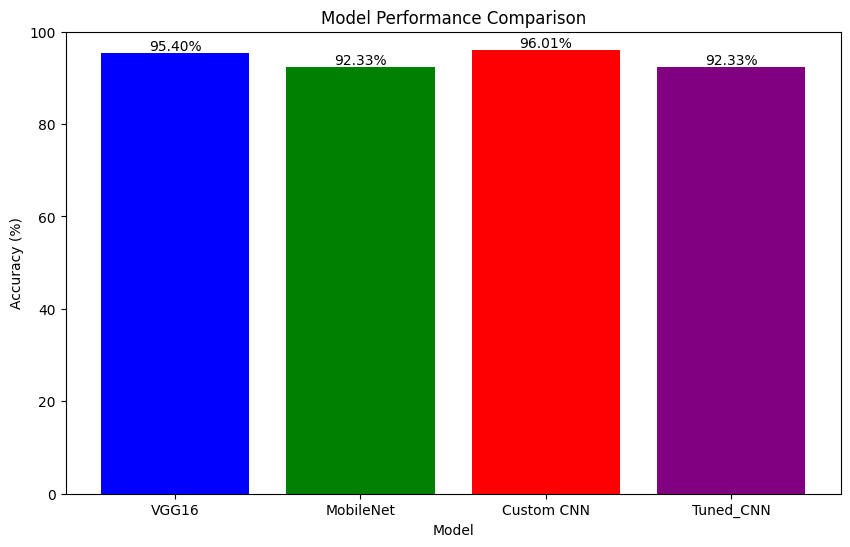

In [67]:
# Evaluate the models on the test set
_, all_model_accuracy = all_model.evaluate(test_tf_data, verbose=0)
_, all_tuned_accuracy = all_tuned.evaluate(test_tf_data, verbose=0)
_, vgg_accuracy = model_vgg.evaluate(test_tf_data, verbose=0)
_, mnet_accuracy = model_Mnet.evaluate(test_tf_data, verbose=0)

# Convert accuracies to percentages
all_model_accuracy *= 100
all_tuned_accuracy *= 100
vgg_accuracy *= 100
mnet_accuracy *= 100

# Define model names and their corresponding accuracies
models = ['VGG16', 'MobileNet', 'Custom CNN', 'Tuned_CNN']
accuracies = [vgg_accuracy, mnet_accuracy, all_model_accuracy, all_tuned_accuracy]

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')  # Added percentage sign for clarity
plt.title('Model Performance Comparison')
plt.ylim(0, 100)  # Optional: Ensures the y-axis starts at 0 and ends at 100
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.5, f'{accuracy:.2f}%', ha='center')  # Optional: Displays the accuracy above each bar
plt.show()


In [68]:
# Predict the values from the test dataset
test_predictions = all_model.predict(test_tf_data)

3/3 [==============================] - 1s 280ms/step


In [69]:
pip install -q -U keras-tuner

#Plot an evaluation matrix

In [71]:
# Initialize lists to store the true labels and the predictions
true_labels = []
predictions = []
true_train_labels = []

In [72]:
# Iterate over the test dataset
for images, labels in test_tf_data.unbatch().batch(1):
  true_labels.append(labels.numpy()[0])
  pred_all = all_model.predict(images)
  pred_VGG16 = model_vgg.predict(images)
  pred_MnetV2 = model_Mnet.predict(images)
# Put the prediction of choice inside the argmax parameter
  predictions.append(np.argmax(pred_VGG16, axis=1)[0])

1/1 [==============================] - 0s 42ms/step


In [73]:
# Convert lists to NumPy arrays so that it can be used in the sklearn functions
true_labels = np.array(true_labels)
predictions = np.array(predictions)

In [74]:
# Generate the classification report
report = classification_report(true_labels, predictions, output_dict=True)
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

In [75]:
# Generate confusion matrix
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1 Score: {f1_score*100:.2f}%')

conf_matrix = confusion_matrix(true_labels, predictions)
print('Confusion Matrix:\n', conf_matrix)

Precision: 94.91%
Recall: 94.16%
F1 Score: 94.48%
Confusion Matrix:
 [[42  1  5  2]
 [ 2 95  1  1]
 [ 1  1 94  0]
 [ 1  0  0 80]]


In [77]:
# Define the class names in a list
class_names = ['Benign', 'Early', 'Pre', 'Pro']

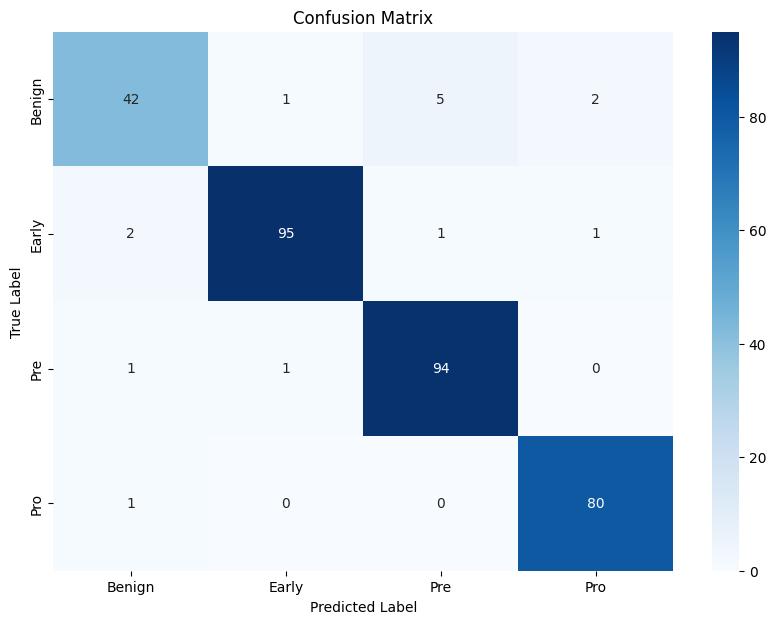

In [78]:
# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Save the model

In [79]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [80]:
# saves as a TensorFlow SavedModel
all_model.save('all_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [81]:
# saves as a TensorFlow SavedModel
all_model.save('all_model.keras')

In [82]:
model_vgg.save('model_vgg.h5')